In [1]:
#import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Look through all folders in the "Project" folder on Google Drive to access dataset
folder_path = '/content/drive/MyDrive/Project'

data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.txt'):
            file_path = os.path.join(root, filename)
            date = os.path.splitext(filename)[0]  # Extract date from filename
            try:
                df = pd.read_csv(file_path, delimiter='\s+', skiprows=[0, 2], encoding='latin1')
                df = df.iloc[:, :16]
                df.columns = ['Time', 'Wind Dir', 'Wind Spd', 'Hum In', 'Humidity', 'Temp In', 'Temp', 'Raw Barom', 'Temp Ch1', 'Hum Ch1', 'Temp Ch2', 'Hum Ch2', 'UV', 'Solar Radiation', 'Dew Point', 'Rain Rate']
                df.insert(0, 'Date', pd.to_datetime(date, format='%y%m%d').strftime('%d-%m-%y'))

                data.append(df)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

Error processing file /content/drive/MyDrive/Project/Dataset_3/120825.txt: No columns to parse from file
Error processing file /content/drive/MyDrive/Project/Dataset_3/121220.txt: Error tokenizing data. C error: Expected 30 fields in line 689, saw 31



In [13]:
# Concatenate all data into a single DataFrame
data = pd.concat(data, ignore_index=True)

# Convert 'date' and 'Time' columns to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M').dt.time
data.sort_values(by=['Date', 'Time'], inplace=True)
data.set_index('Date', inplace=True)

In [16]:
met_data = data.loc['2015-01-16':]
met_data = met_data.iloc[:, :14]
met_data.columns = ['Time', 'Wind Dir', 'Wind Spd', 'Wind Gust', 'Hum In', 'Humidity', 'Temp In', 'Temp', 'Raw Barom', 'UV', 'Solar Radiation', 'Dew Point', 'Daily Rain', 'Rain Rate']
columns_to_keep = ['Time', 'Wind Spd', 'Humidity', 'Temp', 'Solar Radiation', 'Daily Rain']
met_data = met_data[columns_to_keep]

met_data

,Time,Wind Spd,Humidity,Temp,Solar Radiation,Daily Rain
Date,,,,,,
2015-01-16,00:00:00,11.3,77.0,4.80,0.0,8.6
2015-01-16,00:01:00,8.0,77.0,4.80,0.0,0.0
2015-01-16,00:02:00,11.3,77.0,4.80,0.0,0.0
2015-01-16,00:03:00,8.0,77.0,4.80,0.0,0.0
2015-01-16,00:04:00,17.7,77.0,4.80,0.0,0.0
...,...,...,...,...,...,...
2024-05-21,23:24:00,0.0,96.0,13.78,0.0,13.0
2024-05-21,23:25:00,0.0,96.0,13.78,0.0,13.0
2024-05-21,23:26:00,1.6,96.0,13.78,0.0,13.0


In [20]:
met_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4719074 entries, 2015-01-16 to 2024-05-21
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Time             4719074 non-null  object 
 1   Wind Spd         4719074 non-null  float64
 2   Humidity         4719074 non-null  float64
 3   Temp             4719074 non-null  float64
 4   Solar Radiation  4719074 non-null  float64
 5   Daily Rain       4719074 non-null  float64
dtypes: float64(5), object(1)
memory usage: 252.0+ MB


In [22]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
met_data.describe()

,Wind Spd,Humidity,Temp,Solar Radiation,Daily Rain
count,4719074.00,4719074.00,4719074.00,4719074.00,4719074.00
mean,4.97,83.42,10.79,106.59,0.79
std,5.19,12.96,6.08,186.26,2.37
min,0.00,0.00,-17.80,0.00,0.00
25%,0.00,77.00,6.60,0.00,0.00
50%,3.20,88.00,10.44,0.00,0.00
75%,8.00,93.00,14.80,137.00,0.20
max,66.00,98.00,38.89,1252.00,38.20


In [40]:
#Find how many missing days are in the dataset
date_range = pd.date_range(start='2015-01-16', end='2024-05-21', freq='D')

unique_days = pd.to_datetime(met_data.index.date)

missing_days = date_range.difference(unique_days)

print(f"Number of missing days: {len(missing_days)}")
missing_days = pd.DataFrame(missing_days, columns=['Missing Date'])
missing_days

Number of missing days: 130


,Missing Date
0,2019-05-27
1,2019-06-28
2,2019-06-29
3,2019-06-30
4,2019-07-01
...,...
125,2019-10-30
126,2019-10-31
127,2019-11-01
128,2024-03-13


In [23]:
#Create a copy of met_data for EDA where the index is a combination of date and time
met_data_copy = met_data.copy()

#Add the time to the date and set as index
met_data_copy.index = pd.to_datetime(met_data_copy.index, format='%Y-%m-%d')
met_data_copy['Time'] = pd.to_datetime(met_data_copy['Time'], format='%H:%M:%S').dt.time

date_str = met_data_copy.index.date.astype(str)
time_str = met_data_copy['Time'].astype(str)
datetime_str = [f"{date} {time}" for date, time in zip(date_str, time_str)]

met_data_copy.index = pd.to_datetime(datetime_str)

met_data_copy.drop(columns=['Time'], inplace=True) # Drop the old 'Time' column
met_data_copy

,Wind Spd,Humidity,Temp,Solar Radiation,Daily Rain
2015-01-16 00:00:00,11.30,77.00,4.80,0.00,8.60
2015-01-16 00:01:00,8.00,77.00,4.80,0.00,0.00
2015-01-16 00:02:00,11.30,77.00,4.80,0.00,0.00
2015-01-16 00:03:00,8.00,77.00,4.80,0.00,0.00
2015-01-16 00:04:00,17.70,77.00,4.80,0.00,0.00
...,...,...,...,...,...
2024-05-21 23:24:00,0.00,96.00,13.78,0.00,13.00
2024-05-21 23:25:00,0.00,96.00,13.78,0.00,13.00
2024-05-21 23:26:00,1.60,96.00,13.78,0.00,13.00
2024-05-21 23:27:00,1.60,96.00,13.78,0.00,13.00


<ipython-input-26-3b9abc870b7e>:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


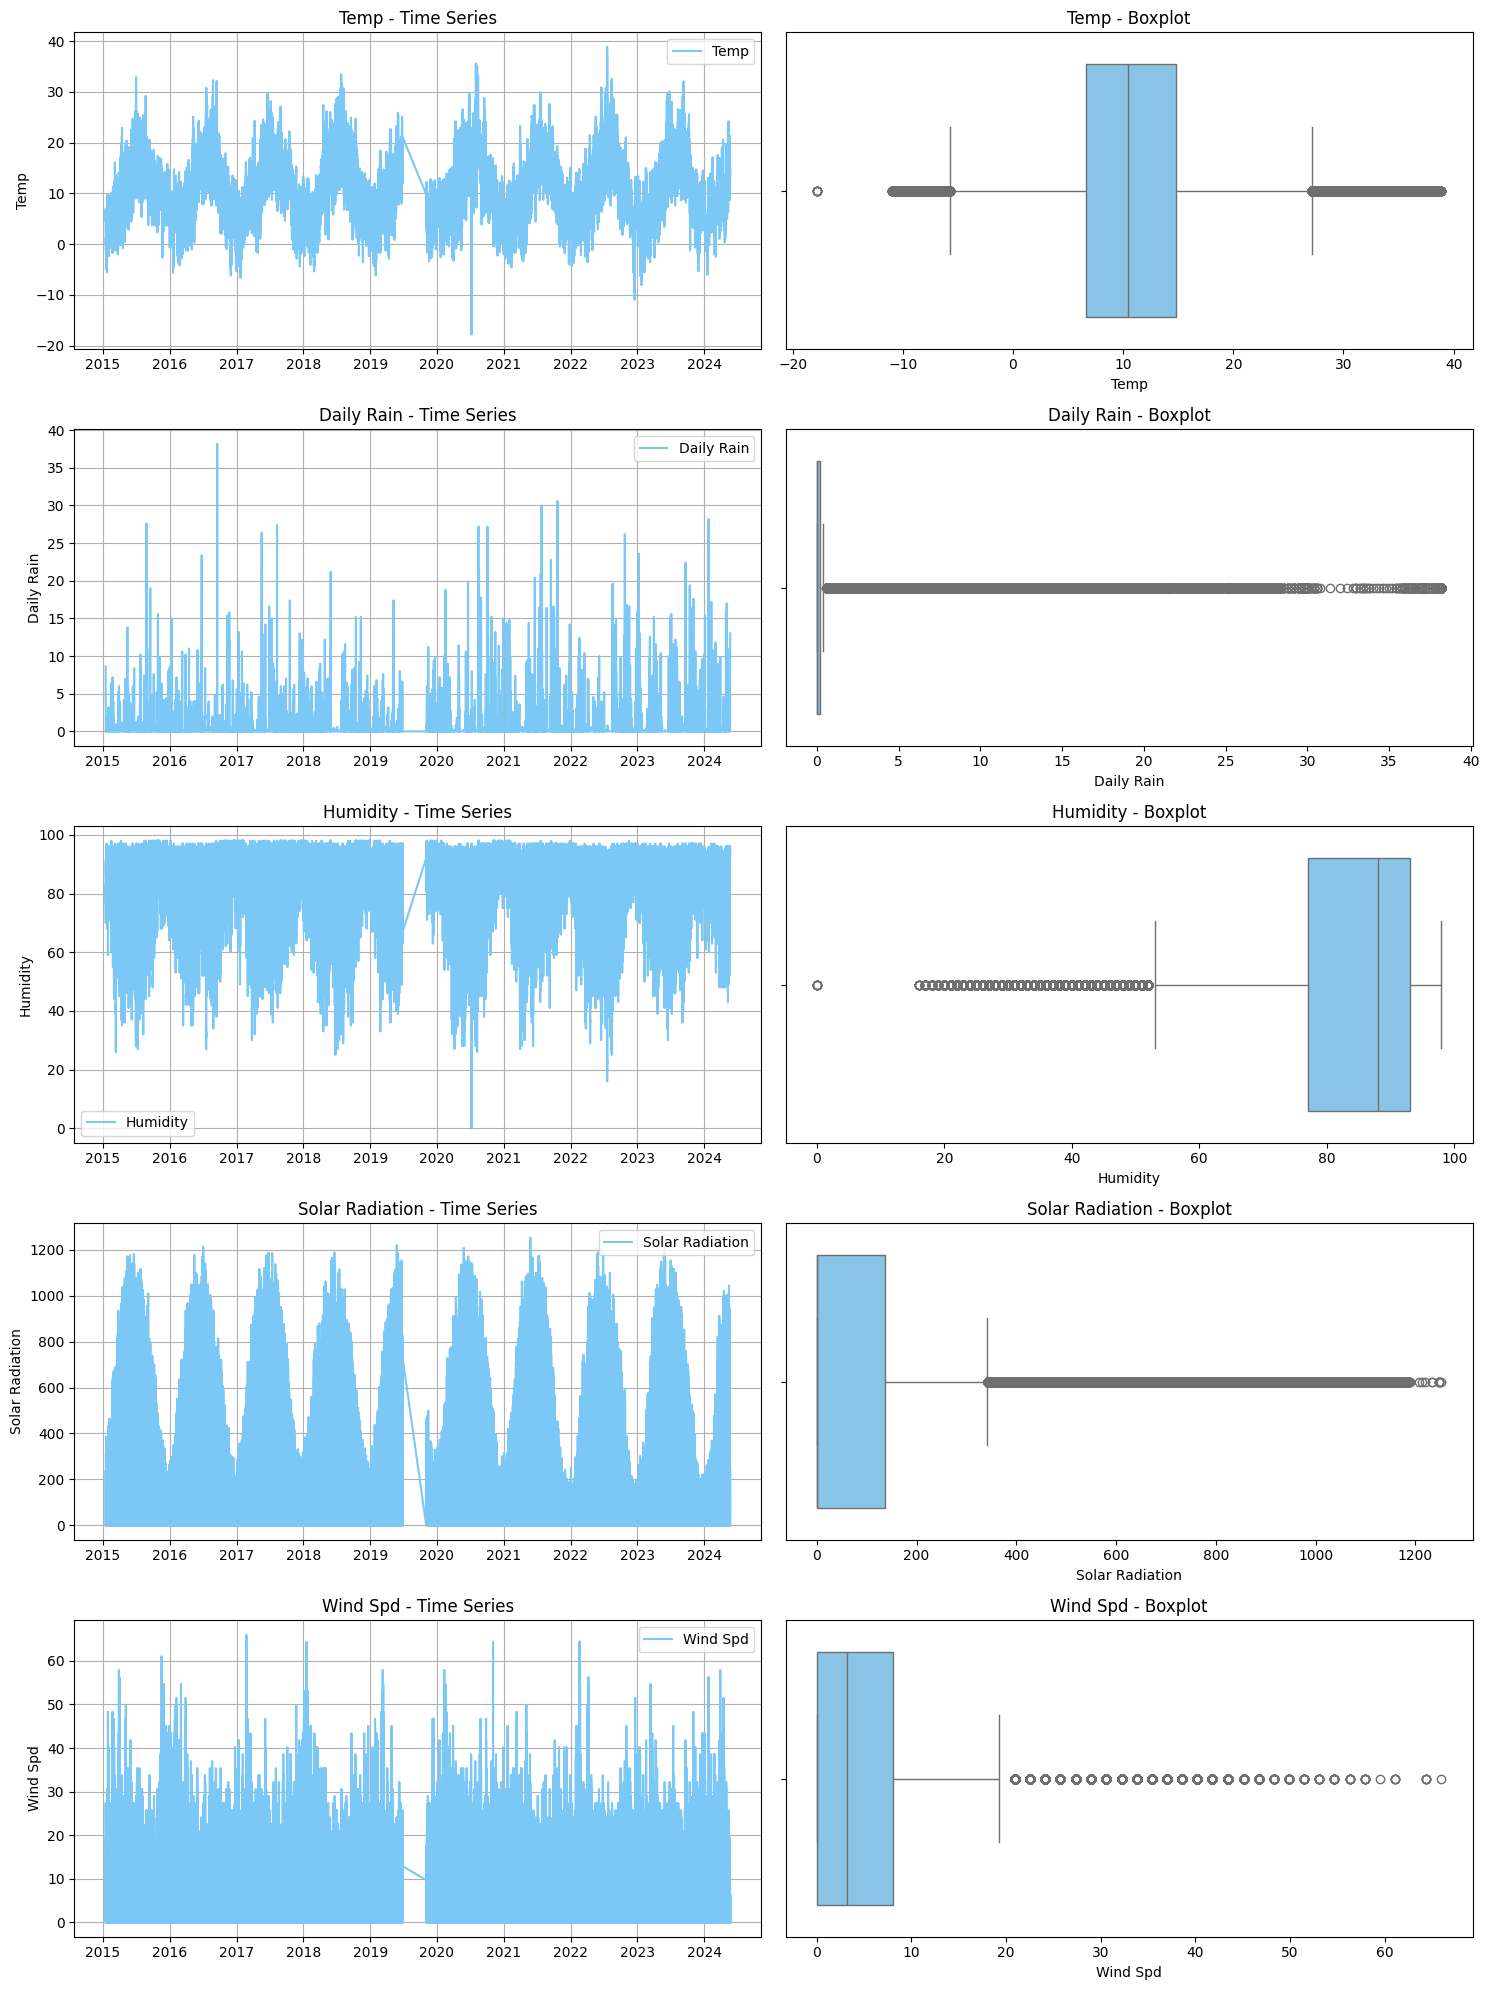

In [26]:
variables = ['Temp', 'Daily Rain', 'Humidity', 'Solar Radiation', 'Wind Spd']

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=False)

for i, var in enumerate(variables):
    # Time Series Plot
    axes[i, 0].plot(met_data_copy.index, met_data_copy[var], label=var, color='xkcd:lightblue')
    axes[i, 0].set_title(f'{var} - Time Series')
    axes[i, 0].set_ylabel(var)
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Boxplot
    sns.boxplot(x=met_data_copy[var], ax=axes[i, 1], color='xkcd:lightblue')
    axes[i, 1].set_title(f'{var} - Boxplot')
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()

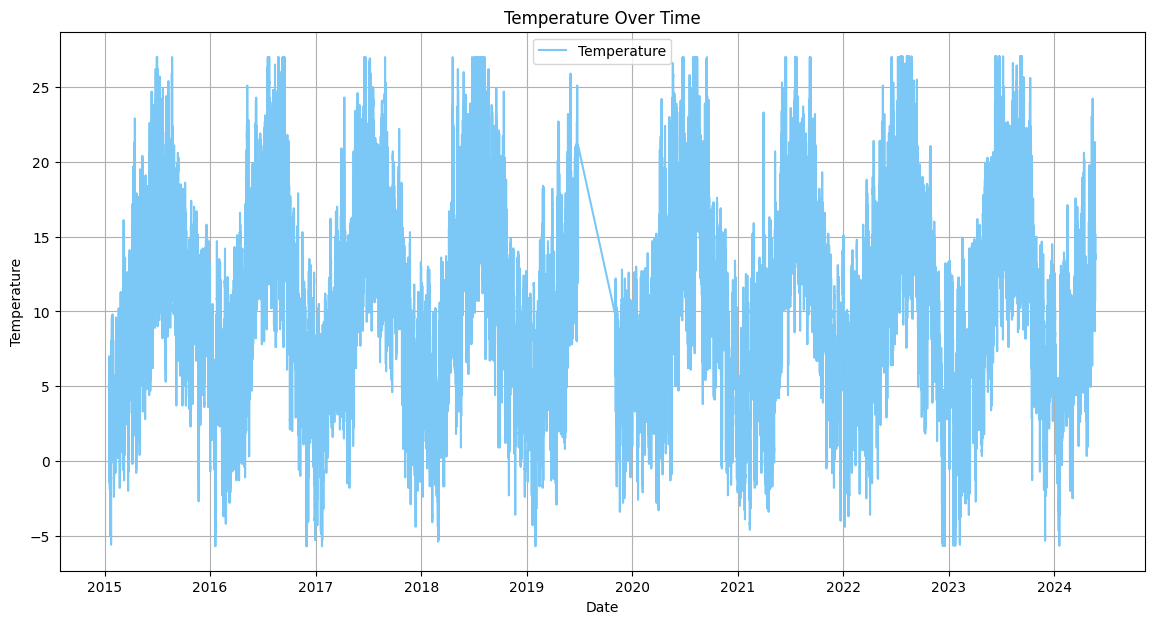

In [27]:
#Attempting to use the interquartile range method to remove outliers in the data

q1_temp = met_data_copy['Temp'].quantile(0.25)
q3_temp = met_data_copy['Temp'].quantile(0.75)
iqr_temp = q3_temp - q1_temp

upper_limit_temp = q3_temp + 1.5 * iqr_temp
lower_limit_temp = q1_temp - 1.5 * iqr_temp
met_data_temp = met_data_copy[(met_data_copy['Temp'] > lower_limit_temp) & (met_data_copy['Temp'] < upper_limit_temp)]

plt.figure(figsize=(14, 7))
plt.plot(met_data_temp.index, met_data_temp['Temp'], label='Temperature', color='xkcd:lightblue')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

#This method of outlier removal will remove some high/low data points that are actually accurate according to met office

In [30]:
#Inspecting all upper and lower outliers

temp_outliers = met_data_copy[(met_data_copy['Temp'] < -10) | (met_data_copy['Temp'] > 30)]
temp_outliers

#confirmed all values as accurate except -17.8 Temp readings in July 2020

,Wind Spd,Humidity,Temp,Solar Radiation,Daily Rain
2015-07-01 09:45:00,8.00,47.00,30.10,684.00,0.00
2015-07-01 09:46:00,9.70,46.00,30.10,680.00,0.00
2015-07-01 09:47:00,12.90,46.00,30.10,684.00,0.00
2015-07-01 09:48:00,6.40,47.00,30.10,686.00,0.00
2015-07-01 09:49:00,11.30,47.00,30.20,686.00,0.00
...,...,...,...,...,...
2023-09-10 13:32:00,12.90,56.00,30.83,462.00,0.00
2023-09-10 13:33:00,12.90,56.00,30.67,441.00,0.00
2023-09-10 13:34:00,4.80,56.00,30.50,425.00,0.00
2023-09-10 13:35:00,3.20,57.00,30.28,468.00,0.00


In [32]:
#Remove the outlier temperature datapoints
met_data_clean = met_data_copy[met_data_copy['Temp'] != -17.8]

In [33]:
#Inspect the outliers for Daily Rain
rain = met_data_copy[met_data_copy['Daily Rain']>30]
rain

#confirmed that there was flooding on 16th Sept 2016 in Hertfordshire

,Wind Spd,Humidity,Temp,Solar Radiation,Daily Rain
2016-09-16 06:28:00,1.60,96.00,16.30,0.00,30.20
2016-09-16 06:29:00,6.40,96.00,16.30,0.00,30.40
2016-09-16 06:30:00,8.00,96.00,16.30,0.00,30.80
2016-09-16 06:31:00,12.90,96.00,16.30,0.00,31.40
2016-09-16 06:32:00,6.40,96.00,16.30,0.00,32.00
...,...,...,...,...,...
2021-10-20 23:56:00,4.80,94.00,8.40,0.00,30.60
2021-10-20 23:57:00,6.40,94.00,8.40,0.00,30.60
2021-10-20 23:58:00,8.00,94.00,8.40,0.00,30.60
2021-10-20 23:58:00,9.70,94.00,8.40,0.00,30.60


In [35]:
#Inspect outliers for humidity
humidity = met_data_copy[met_data_copy['Humidity']<20]
humidity

,Wind Spd,Humidity,Temp,Solar Radiation,Daily Rain
2020-07-07 20:57:00,0.00,0.00,-17.80,0.00,0.00
2020-07-07 20:58:00,0.00,0.00,-17.80,0.00,0.00
2020-07-07 20:59:00,0.00,0.00,-17.80,0.00,0.00
2020-07-07 21:03:00,0.00,0.00,-17.80,0.00,0.00
2020-07-07 21:04:00,0.00,0.00,-17.80,0.00,0.00
...,...,...,...,...,...
2022-07-19 14:44:00,22.50,19.00,38.28,613.00,0.00
2022-07-19 14:45:00,17.70,19.00,38.17,612.00,0.00
2022-07-19 14:46:00,9.70,19.00,38.06,608.00,0.00
2022-07-19 14:47:00,12.90,19.00,38.06,608.00,0.00


In [36]:
#Remove the outlier humidity datapoints
met_data_clean = met_data_copy[met_data_copy['Humidity'] != 0]

<ipython-input-38-6790f3793c95>:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


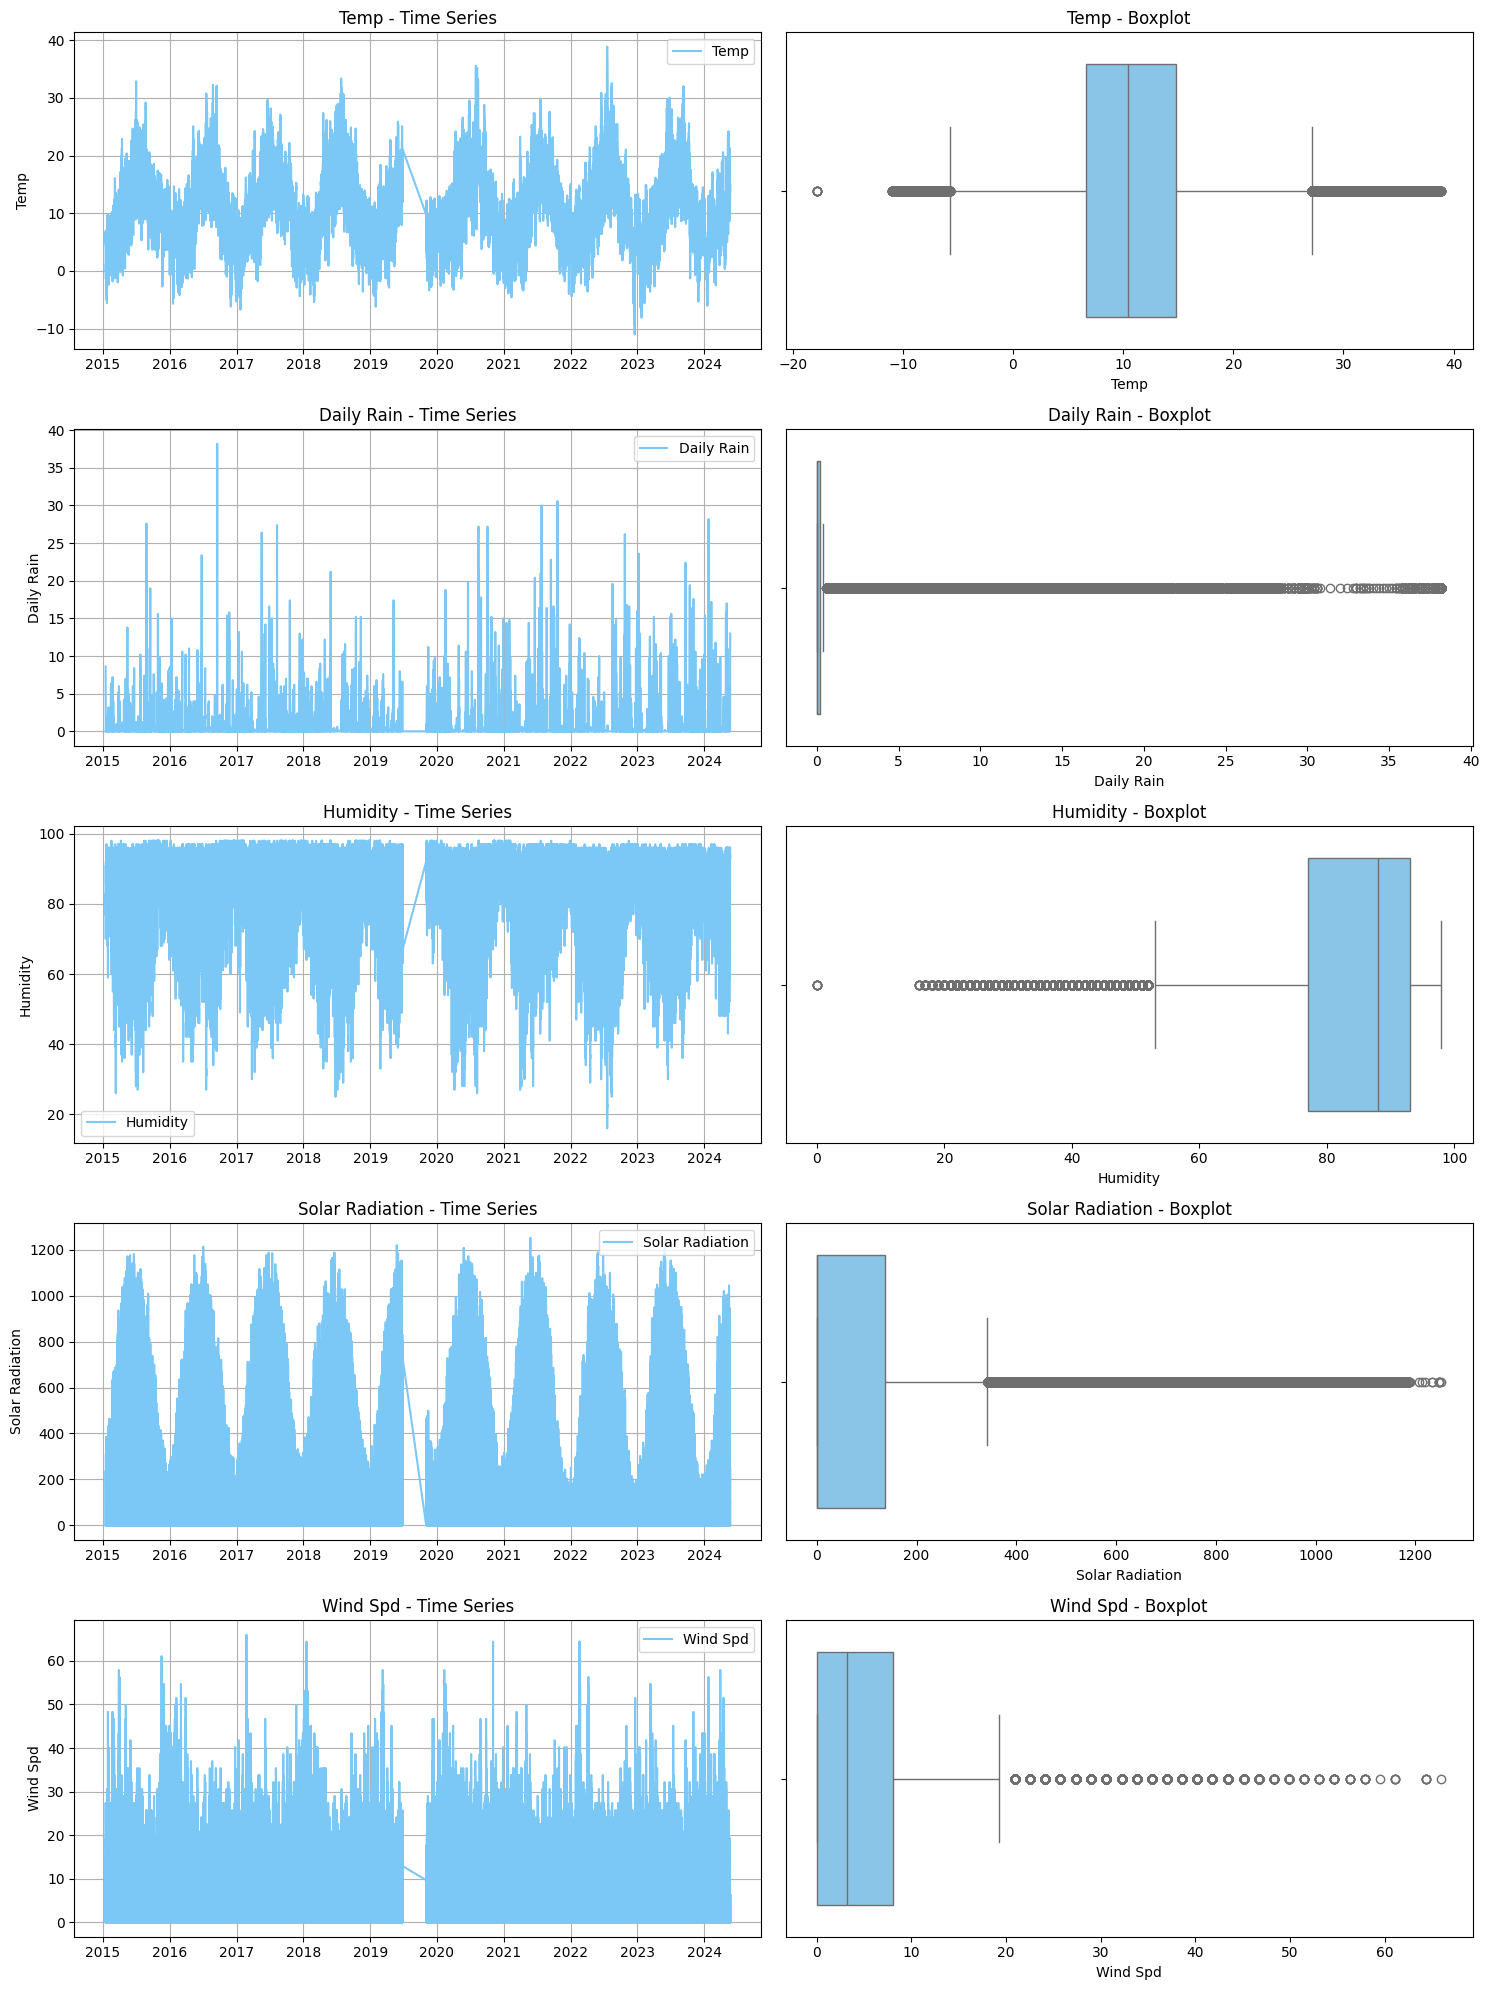

In [38]:
#Plot Data after removing outliers
variables = ['Temp', 'Daily Rain', 'Humidity', 'Solar Radiation', 'Wind Spd']

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=False)

for i, var in enumerate(variables):
    # Time Series Plot
    axes[i, 0].plot(met_data_clean.index, met_data_clean[var], label=var, color='xkcd:lightblue')
    axes[i, 0].set_title(f'{var} - Time Series')
    axes[i, 0].set_ylabel(var)
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Boxplot
    sns.boxplot(x=met_data_copy[var], ax=axes[i, 1], color='xkcd:lightblue')
    axes[i, 1].set_title(f'{var} - Boxplot')
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

sns.heatmap(met_data_clean, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout